# A more detailed analysis of TNNI1 (and other genes included in the study)

Ralf suggested that we produce a little bit more insight into the gene which gives us the strongest signal in the dataset, specifically TNNI1 (and other genes, e.g. RYR1). Usual precautions with multiplicity, [aka look-elsewhere effect](https://en.wikipedia.org/wiki/Look-elsewhere_effect), apply. Specifically, the TNNI1 gene was chosen after we had seen the data – it was selected from DM1-APA, which is a list of ~40 genes as identified by Charles Thornton's group in their DM1 alternative polyadenylation paper (Batra et al.).

# GTF annotation and probe filtering

I feel I should start by describing the structure of the annotation file as obtained from GENECODE. The exact file I'm referring to is "gencode.v26lift37.annotation.gtf", but the description will hold of other GENECODE files with the gtf extension.

This is a small snippet of the gtf file, looking at a subset of TNNI1 annotations

```
chr1    HAVANA  gene    201372896       201398994       .       -       .       gene_id "ENSG00000159173.18_2"; gene_type "protein_coding"; gene_name "TNNI1"; level 2; havana_gene "OTTHUMG00000035736.6_2"; remap_status "full_contig"; remap_num_mappings 1; remap_target_status "overlap";
chr1    ENSEMBL transcript      201372896       201390874       .       -       .       gene_id "ENSG00000159173.18_2"; transcript_id "ENST00000622580.4_1"; gene_type "protein_coding"; gene_name "TNNI1"; transcript_type "protein_coding"; transcript_name "TNNI1-201"; level 3; protein_id "ENSP00000477578.1"; transcript_support_level 1; tag "basic"; tag "appris_alternative_1"; havana_gene "OTTHUMG00000035736.6_2"; remap_num_mappings 1; remap_status "full_contig"; remap_target_status "new";
chr1    ENSEMBL exon    201390801       201390874       .       -       .       gene_id "ENSG00000159173.18_2"; transcript_id "ENST00000622580.4_1"; gene_type "protein_coding"; gene_name "TNNI1"; transcript_type "protein_coding"; transcript_name "TNNI1-201"; exon_number 1; exon_id "ENSE00001632535.1_1"; level 3; protein_id "ENSP00000477578.1"; transcript_support_level 1; tag "basic"; tag "appris_alternative_1"; havana_gene "OTTHUMG00000035736.6_2"; remap_original_location "chr1:-:201421673-201421746"; remap_status "full_contig";
chr1    ENSEMBL exon    201386911       201386940       .       -       .       gene_id "ENSG00000159173.18_2"; transcript_id "ENST00000622580.4_1"; gene_type "protein_coding"; gene_name "TNNI1"; transcript_type "protein_coding"; transcript_name "TNNI1-201"; exon_number 2; exon_id "ENSE00001350131.1_1"; level 3; protein_id "ENSP00000477578.1"; transcript_support_level 1; tag "basic"; tag "appris_alternative_1"; havana_gene "OTTHUMG00000035736.6_2"; remap_original_location "chr1:-:201417783-201417812"; remap_status "full_contig";
chr1    ENSEMBL CDS     201386911       201386921       .       -       0       gene_id "ENSG00000159173.18_2"; transcript_id "ENST00000622580.4_1"; gene_type "protein_coding"; gene_name "TNNI1"; transcript_type "protein_coding"; transcript_name "TNNI1-201"; exon_number 2; exon_id "ENSE00001350131.1"; level 3; protein_id "ENSP00000477578.1"; transcript_support_level 1; tag "basic"; tag "appris_alternative_1"; havana_gene "OTTHUMG00000035736.6_2"; remap_original_location "chr1:-:201417783-201417793"; remap_status "full_contig";
```

As you can see, the annotation data is strongly denormalised, with a lot of information repeated across the lines. The first line corresponds to the entire gene, most importantly which chromosome it's located on, which consortium identified it, where it starts and where it ends (in reference to GRch37), which strand it's on (reverse), etc.

The next line contains information about the first transcript. This is followed by the information about all exons belonging to the transcript, one line per exon. Then the second transcript follows, etc.

I'd like to focus on three pieces of information present in the file. Firstly the annotation type, which is located the third column in the GTF file. We can already see the following possibilites:

1. gene
2. transcript
3. exon
4. CDS

We're actually going to generate a list of all possible annotations, across the entire GENECODE, using a short python script below

In [1]:
genecode_file = "annotations/gencode.v26lift37.annotation.gtf"

In [2]:
possible_annotation_types = set()
with open(genecode_file) as geneList:
    for i, line in enumerate(geneList):
        if line and line[0] == "#":
            continue

        line = line.rstrip().split("\t")
        chromo, source, typ, left, right, _, strand, _, meta = line
        possible_annotation_types.add(typ)

In [3]:
possible_annotation_types

{'CDS',
 'Selenocysteine',
 'UTR',
 'exon',
 'gene',
 'start_codon',
 'stop_codon',
 'transcript'}

The other two bits of information are "gene_type" and "transcript_type". These are both included in the last column of the gtf file. If we restrict our attention to annotation types "CDS" (Coding sequence) and "UTR", the following are all possible combinations of annotation type, ranscript type and gene type.

In [4]:
import re

def unquote(s):
    if len(s) >= 2 and s[0] == '"' and s[-1] == '"':
        return s[1:-1]
    return s

feature_types = set()
with open(genecode_file) as geneList:
    for i, line in enumerate(geneList):
        if line and line[0] == "#":
            continue

        line = line.rstrip().split("\t")
        chromo, source, typ, left, right, _, strand, _, meta = line
        left = int(left)
        right = int(right)
        meta = re.split(";[ ]?", meta)

        processed_meta = {}
        for m in meta[:-1]:
            k, v = m.split()
            processed_meta[k] = unquote(v)

        transcript_type =  processed_meta.get("transcript_type", "")
        gene_type = processed_meta.get("gene_type", "")

        protein_coding = transcript_type == "protein_coding" or gene_type == "protein_coding"
        is_coding_or_UTR = typ in ["CDS", "UTR"]
        if is_coding_or_UTR:
            feature_types.add((typ, transcript_type, gene_type))

In [5]:
feature_types

{('CDS', 'IG_C_gene', 'IG_C_gene'),
 ('CDS', 'IG_D_gene', 'IG_D_gene'),
 ('CDS', 'IG_J_gene', 'IG_J_gene'),
 ('CDS', 'IG_V_gene', 'IG_V_gene'),
 ('CDS', 'TR_C_gene', 'TR_C_gene'),
 ('CDS', 'TR_D_gene', 'TR_D_gene'),
 ('CDS', 'TR_J_gene', 'TR_J_gene'),
 ('CDS', 'TR_V_gene', 'TR_V_gene'),
 ('CDS', 'non_stop_decay', 'protein_coding'),
 ('CDS', 'nonsense_mediated_decay', 'polymorphic_pseudogene'),
 ('CDS', 'nonsense_mediated_decay', 'protein_coding'),
 ('CDS', 'polymorphic_pseudogene', 'polymorphic_pseudogene'),
 ('CDS', 'protein_coding', 'IG_C_gene'),
 ('CDS', 'protein_coding', 'IG_V_gene'),
 ('CDS', 'protein_coding', 'TR_V_gene'),
 ('CDS', 'protein_coding', 'polymorphic_pseudogene'),
 ('CDS', 'protein_coding', 'protein_coding'),
 ('UTR', 'IG_C_gene', 'IG_C_gene'),
 ('UTR', 'IG_D_gene', 'IG_D_gene'),
 ('UTR', 'IG_J_gene', 'IG_J_gene'),
 ('UTR', 'IG_V_gene', 'IG_V_gene'),
 ('UTR', 'TR_C_gene', 'TR_C_gene'),
 ('UTR', 'TR_V_gene', 'TR_V_gene'),
 ('UTR', 'non_stop_decay', 'protein_coding'),
 

In the pipeline that was used to filter the microarray data in the paper we only select Affymetrix probes which are fully contained (coordinate-wise) in annotations of type "CDS" or "UTR", where gene_type is "protein_coding" and transcript_type is "protein_coding", i.e. only probes which have to the following combination of annotation/transcript/gene types

In [6]:
{('CDS', 'protein_coding', 'protein_coding'), ('UTR', 'protein_coding', 'protein_coding')}

{('CDS', 'protein_coding', 'protein_coding'),
 ('UTR', 'protein_coding', 'protein_coding')}

The reason we do this is because we want to select only the probes with the highest possibility of carrying biological signal, e.g. probes which target protein coding regions. We found default Affymetrix annotation overly inclusive, and additional noise added in form of *probes which might be interesting* signficantly dilutes much stronger signal that comes from the *high quality* probes, as filtered using the process outlined above.

# Linear models on TNNI1

One of the capabilities of the pipeline presented in the paper is producing a file for each GENECODE gene, which has the following format (e.g. looking at TNNI1)

```
gene_name	probeset_id	seq5to3plus	chrom	strand	genocode_left	genecode_right	x	y	patient_111747589	patient_117440822	patient_124563003	patient_129523253	patient_159834720	patient_230974357	patient_270148799	patient_315805040	patient_321962190	patient_328687703	patient_360448352	patient_377666471	patient_387939296	patient_420299717	patient_427374914	patient_449599671	patient_473208969	patient_549452228	patient_572448109	patient_575039926	patient_597785396	patient_661252781	patient_819054051	patient_830225708	patient_873750289	patient_881676366	patient_896445336	
TNNI1	2450824	TGAATGAGGTGATAAGACCCACGCC	chr1	-	201373522	201373546	340	565	7.524998198670614	7.632704288131665	6.757062096264637	5.703956103742427	4.361966127309749	4.527444685792158	7.145013000084781	6.430570146610593	6.873504457278666	7.016365847790489	7.283509915374051	7.344535463786038	8.037950403202343	7.649219836426274	5.388395179112687	6.931524833091131	6.587620600277559	6.608513593208346	6.891438087635299	7.121122667465483	7.719781758957822	7.314552994462941	7.714998485542919	7.861962859429527	7.303624313595454	4.075387632576693	4.968325915906333	
TNNI1	2450824	CATAAGGGCTTCAAAAGTATGTGCC	chr1	-	201373048	201373072	900	1871	6.6185908255772015	6.79555423937187	5.815317191213048	4.695882946498068	4.004387526966276	3.7602185964870363	5.953493104847751	5.931645924875645	5.976002044039466	6.420422338023729	6.286376712728965	6.3811264552461004	6.826553257053195	6.604847373960939	4.9779339571112144	6.197822192537814	5.6918008036463466	5.8732416987804905	5.814399566527766	6.594884482044835	6.750887178283762	6.508009352829585	6.727771458730715	6.9512571601389235	6.69770587816795	3.6803057270761124	4.316667671655048
```

The first column is the gene_name, followed by important information about each probe, such as the probe sequence (a 25-mer, always in relation to the plus strand, from 5' to 3'), which coordinates the probe maps in the genome, where physically the probe maps on the chip, etc. This is followed by (quantile) normalised and logged expression values from the microarray chip, corresponding to patient IDs.

We can load this data into python to enable subsequent analysis with linear models. This is what we need to do to make it work:
1. Load patient's metadata, i.e. repeat length, MIRS, etc.
2. Load the two lists of genes identified in Charles Thornton's group: DM1-AS (Nakamori et al.) and DM1-AP (Batra et al).
3. Load the probe data corresponding to these genes.
4. Combine all of the above data in a single, easy to use data structure.

Let's first load some helper functions

In [166]:
import os
import numpy
genecode_genes = set(os.listdir("experiment_blood"))

In [167]:
# copied from predictions.ipynb
class Metadata:
    def __init__(self, ids, cels, metadata):
        self.IDs = ids
        self.CELs = cels
        self.modal_allele = [int(metadata[i]["modal_allele"]) for i in ids]
        self.progenitor_allele = [int(metadata[i]["progenitor_allele"]) for i in ids]
        self.MIRS = [int(metadata[i]["MIRS"]) for i in ids]
    def __str__(self):
        return "Metadata={{IDs: {}...,\n CELs: {}...,\n modal_allele: {}...,\n progenitor_allele: {}...,\n MIRS: {}...}}".format(self.IDs[:5], self.CELs[:5], self.modal_allele[:5], self.progenitor_allele[:5], self.MIRS[:5])
    def __repr__(self):
        return self.__str__()

def load_metadata():
    metadata = {}
    metadata_order = []
    with open("metadata.txt") as f:
        for i, line in enumerate(f):
            line = line.strip().split()
            if i == 0:
                names = line[1:]
            else:
                values = line[1:]
                patient_id = line[0]
                metadata_order.append(patient_id)
                metadata[patient_id] = {k: v for k, v in zip(names, values)}
    blood_IDs = [i for i in metadata_order]
    muscle_IDs = [i for i in metadata_order if metadata[i]["muscle_cel"] != "refused_biopsy"]
    blood_CELs = [metadata[i]["blood_cel"] for i in blood_IDs]
    muscle_CELs = [metadata[i]["muscle_cel"] for i in muscle_IDs]
        
    blood_record = Metadata(blood_IDs, blood_CELs, metadata)
    muscle_record = Metadata(muscle_IDs, muscle_CELs, metadata)
    return blood_record, muscle_record

In [168]:
# copied from predictions.ipynb
def load_genes(filename):
    genes = set()
    repeated = set()
    with open(filename) as f:
        for line in f:
            line = line.rstrip()
            if line in genes:
                repeated.add(line)
            genes.add(line)
    failed = genes.difference(genecode_genes)
    if repeated:
        print("These genes appear more than once: {}".format([g for g in repeated]))
    if failed:
        print("Couldn't identify the following genes: {}".format([g for g in failed]))
    return genes.intersection(genecode_genes)

In [169]:
# copied from predictions.ipynb
def produce_data(meta, gene_names, experiment):
    IDs = meta.IDs
    probe_data = []
    probe_IDs = []
    for gene in gene_names:        
        with open(os.path.join(experiment, gene)) as f:
            for i, line in enumerate(f):
                line = line.rstrip().split()
                if i == 0:
                    prefix = "patient_"
                    our_IDs = [elem[len(prefix):] for elem in line if re.match(prefix, elem)]
                    try:
                        assert IDs == our_IDs
                    except AssertionError:
                        print(gene)
                    headers = {header: i for i, header in enumerate(line)}
                    patient_data = {header[len(prefix):]: i for i, header in enumerate(line) if re.match(prefix, header)}
                    def write_signature(line):
                        signature = []
                        for elem in ["gene_name", "probeset_id", "seq5to3plus", "chrom", "strand", "genocode_left", "genecode_right"]:
                            signature.append(line[headers[elem]])
                        return signature
                else:
                    probe_ID = write_signature(line)
                    rv = []
                    for patient_id in IDs:
                        rv.append(float(line[patient_data[patient_id]]))
                    probe_data.append(rv)
                    probe_IDs.append(probe_ID)
    probe_data = numpy.array(probe_data)
    return probe_data, probe_IDs

After importing these helper functions, we can now we can load the metadata

In [170]:
metadata = load_metadata()

In [171]:
metadata

(Metadata={IDs: ['111747589', '117440822', '124563003', '129523253', '141772399']...,
  CELs: ['111747589_B.CEL', '117440822_B.CEL', '124563003_B.CEL', '129523253_B.CEL', '141772399_B.CEL']...,
  modal_allele: [872, 297, 593, 408, 717]...,
  progenitor_allele: [600, 227, 301, 211, 320]...,
  MIRS: [4, 2, 4, 4, 2]...},
 Metadata={IDs: ['111747589', '117440822', '124563003', '129523253', '159834720']...,
  CELs: ['111747589_M.CEL', '117440822_M.CEL', '124563003_M.CEL', '129523253_M.CEL', '159834720_MR.cel']...,
  modal_allele: [872, 297, 593, 408, 1035]...,
  progenitor_allele: [600, 227, 301, 211, 695]...,
  MIRS: [4, 2, 4, 4, 4]...})

It's muscle metadata that we're interested in

In [172]:
muscle_metadata = metadata[1]

In [173]:
muscle_metadata

Metadata={IDs: ['111747589', '117440822', '124563003', '129523253', '159834720']...,
 CELs: ['111747589_M.CEL', '117440822_M.CEL', '124563003_M.CEL', '129523253_M.CEL', '159834720_MR.cel']...,
 modal_allele: [872, 297, 593, 408, 1035]...,
 progenitor_allele: [600, 227, 301, 211, 695]...,
 MIRS: [4, 2, 4, 4, 4]...}

And we can load both lists of genes

In [174]:
nakamori = load_genes("nakamori_genes.txt")

These genes appear more than once: ['LDB3', 'DMD', 'PHKA1']


In [175]:
print(nakamori)

{'ANK2', 'ALPK3', 'DTNA', 'VPS39', 'PHKA1', 'MBNL2', 'VEGFA', 'RYR1', 'UBE2D3', 'CAPZB', 'IMPDH2', 'TTN', 'FHOD1', 'MLF1', 'COPZ2', 'NFIX', 'INSR', 'BIN1', 'CAPN3', 'CAMK2B', 'DMD', 'ATP2A2', 'USP25', 'MBNL1', 'PDLIM3', 'NRAP', 'LDB3', 'ARFGAP2', 'TXNL4A', 'ATP2A1', 'ABLIM2', 'TBC1D15', 'GFPT1', 'KIF13A', 'CACNA1S', 'CLCN1', 'OPA1', 'SOS1'}


In [176]:
batra = load_genes("batra_genes.txt")

These genes appear more than once: ['LDB3', 'SNX1', 'SMIM3', 'TPM3', 'CEBPA', 'NDUFB10', 'TNNI1', 'CHRNA1', 'PDLIM5', 'IDH3A', 'MEF2B', 'ASPH', 'TPM2', 'TPM1', 'TTYH3', 'PCM1', 'DNAJB6']


In [177]:
print(batra)

{'SNX1', 'ATP5E', 'DAPK2', 'ABCA1', 'MBNL2', 'AMHR2', 'MGP', 'NDUFB10', 'PFKFB2', 'TMEM38B', 'PDLIM2', 'DST', 'TJP2', 'KDELR1', 'PCM1', 'SLC25A36', 'SPATS2L', 'DVL3', 'SMIM3', 'RTN2', 'PCBD2', 'ARHGEF7', 'MDN1', 'ALG3', 'NUP43', 'CIRBP', 'CEBPA', 'COPS4', 'PEBP4', 'BRSK2', 'GPS1', 'KRBA1', 'U2SURP', 'LMNA', 'FASTK', 'TPM2', 'OSBPL1A', 'PLIN2', 'SPTB', 'MORC3', 'SETD3', 'CDC42', 'EZR', 'MYH6', 'SPEG', 'BRWD1', 'KCNK7', 'TNNI1', 'CELF1', 'PDLIM5', 'RIN1', 'IDH3A', 'AP1G1', 'MEF2B', 'ILF3', 'MEF2D', 'TTYH3', 'PCMT1', 'KIF1B', 'DNAJB6', 'LDB3', 'CACNA1G', 'HDAC11', 'MEF2C', 'TGFBI', 'TBL2', 'NR2F1', 'CACNB1', 'CHRNA1', 'DES', 'LAMP2', 'MTCH1', 'AGL', 'ASPH', 'CLDND1', 'TPM3', 'TPM1', 'PIK3C2B', 'RAB24', 'SAMD4A'}


And (quantile normalised and logged) expression levels

In [178]:
expression, probe_data = produce_data(metadata[1], ["TNNI1"], "experiment_muscle")

In [179]:
expression

array([[7.5249982 , 7.63270429, 6.7570621 , ..., 7.30362431, 4.07538763,
        4.96832592],
       [6.61859083, 6.79555424, 5.81531719, ..., 6.69770588, 3.68030573,
        4.31666767],
       [7.11576526, 7.47369801, 6.50871331, ..., 7.08512177, 4.8287062 ,
        5.47282844],
       ...,
       [6.31846032, 5.64445534, 6.27299961, ..., 5.48287922, 3.98250503,
        4.89285742],
       [6.37941085, 5.96674352, 6.56266215, ..., 5.68082759, 5.5058914 ,
        5.72326538],
       [6.67036122, 5.93323466, 6.62628665, ..., 5.85159698, 4.05114774,
        4.49419051]])

The first number represents rows and corresponds to the total number of probes present in the dataset. The second number represents columns and that corresponds to the total number of patients present in the dataset.

In [180]:
expression.shape

(60, 27)

We also have the variable `probe_data`, which tells us important information about the probes, e.g.:
    1. TNNI1 – gene name
    2. 2450824 – probeset ID
    3. TGAATGAGGTGATAAGACCCACGCC – probe sequence
    4. chr1 – sequence ID
    4. - – strand
    5. 201373522, 201373546 – 5', 3' coordinates on the plus strand

In [181]:
probe_data[0:3]

[['TNNI1',
  '2450824',
  'TGAATGAGGTGATAAGACCCACGCC',
  'chr1',
  '-',
  '201373522',
  '201373546'],
 ['TNNI1',
  '2450824',
  'CATAAGGGCTTCAAAAGTATGTGCC',
  'chr1',
  '-',
  '201373048',
  '201373072'],
 ['TNNI1',
  '2450824',
  'CAGCTGGCTCGAGGTCACATCCTGA',
  'chr1',
  '-',
  '201373418',
  '201373442']]

And finally our independent variable – the repeat length

In [182]:
print(muscle_metadata.modal_allele)

[872, 297, 593, 408, 1035, 993, 740, 1111, 290, 654, 11, 261, 12, 186, 1261, 1000, 345, 604, 12, 83, 12, 999, 561, 77, 240, 866, 697]


We can now produce a simple linear regression for each probe against all `modal_allele` lengths. However, it would be very difficult to look at 60 plots at once and gain any useful insight in this way. There's a better visualisation method, but let's worry about it later.

Here's what a single probeset would look like when visualised in this way

In [195]:
probeset_id = "2450829"
[elem for elem in probe_data if elem[1] == probeset_id]

[['TNNI1',
  '2450829',
  'GTGCCTTAGTCCGTGCATCCGTGCA',
  'chr1',
  '-',
  '201379335',
  '201379359'],
 ['TNNI1',
  '2450829',
  'TGCATCCCAGGTGATGTAGACGCTG',
  'chr1',
  '-',
  '201379147',
  '201379171'],
 ['TNNI1',
  '2450829',
  'CCCAGGAGAGCCGACTCAAATCAGT',
  'chr1',
  '-',
  '201379303',
  '201379327'],
 ['TNNI1',
  '2450829',
  'CATGCCCAAGTATCATGGTGCTGGA',
  'chr1',
  '-',
  '201379266',
  '201379290']]

We select the data corresponding to the probeset from the expression matrix

In [196]:
expression_indices = [i for i, elem in enumerate(probe_data) if elem[1] == probeset_id]

In [197]:
expression_indices

[48, 49, 50, 51]

In [203]:
data_to_plot = expression[expression_indices,:]

In [204]:
data_to_plot

array([[6.57308804, 7.36298423, 6.39836317, 5.30978258, 5.04523425,
        4.97705895, 6.46669225, 5.8746014 , 6.14555934, 6.62941109,
        7.22992028, 6.9704662 , 7.59874399, 7.2519373 , 4.98525499,
        6.07472231, 6.31672836, 5.8032875 , 6.50353846, 7.22194721,
        7.06038771, 6.54994586, 7.13754983, 7.39422532, 7.40784557,
        4.8310453 , 5.00847113],
       [5.75280881, 6.31861188, 5.85888554, 4.62477174, 4.31412686,
        4.29240147, 6.03475538, 4.84047904, 5.37033307, 6.16730599,
        6.49945297, 5.9541898 , 6.79370818, 6.41248875, 4.5547972 ,
        5.33488611, 5.87647453, 5.67712924, 5.62184582, 6.28244381,
        6.54969981, 6.18142688, 6.53053693, 6.67940798, 6.64872729,
        4.31370357, 4.8426154 ],
       [5.97080311, 6.63753327, 6.17443496, 5.23265502, 4.68672383,
        4.61520703, 5.81612371, 5.16214638, 5.58258338, 5.90362015,
        6.49204263, 6.32946375, 6.41227987, 6.53633342, 5.01070119,
        5.47006483, 5.84520198, 5.22458042, 5.7888

And finally we can produce the desired plots. Each plot corresponds to one probe. There are four probes in the probeset – and therefore four plots. On the x axis we have the modal allele (see the line of code, which reads `x = muscle_metadata.modal_allele`). On the y axis we have expression levels of the relevant probes.

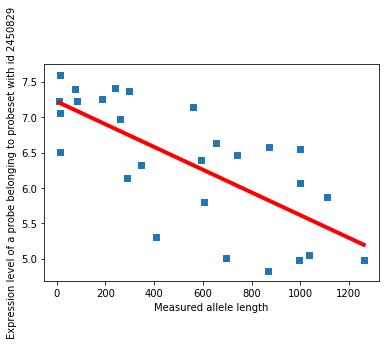

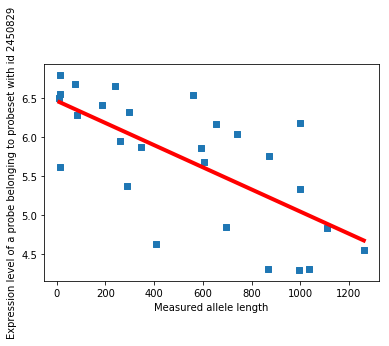

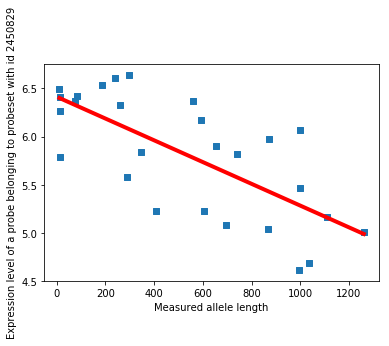

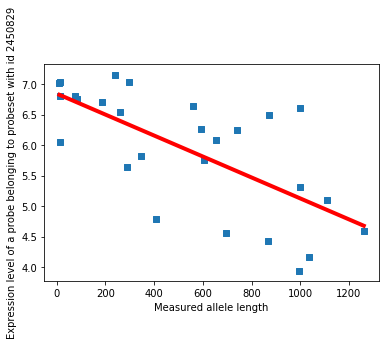

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(len(expression_indices)):
    plt.figure()
    x = muscle_metadata.modal_allele
    y = data_to_plot[i]
    plt.scatter(x, y, marker=",")
    plt.plot(numpy.unique(x), numpy.poly1d(numpy.polyfit(x, y, 1))(numpy.unique(x)), linewidth=4, color="r")
    plt.xlabel("Measured allele length")
    plt.ylabel("Expression level of a probe belonging to probeset with id {}".format(probeset_id))

# Better plots of TNNI1 ("butterfly plots")

As explained earlier it is actually very difficult to digest in the order of 50–500 plots per gene (and tens of thousands of plots per gene set!) and I don't think it's very helpful in generating human understanding. What we can do however, is generate p-values for each of these plots, log them, sign them (multiply each logged p-value by the absolute value of the corresponding slope) and plot these against the genomic coordinates of the probeset (unfortunately we don't get genomic coordinates of individual probes from Affymetrix; it's something we could potentially get from re-doing their alignment, but it's a minor problem, not really worth the effort to spend fixing). I call these plots "butterfly plots", because I draw symmetric signed p-value cut-offs (and Bonferroni corrected p-value cut-offs) on both sides of the x axis.

Let's import an interactive plotting library

In [206]:
import plotly.offline as off
off.init_notebook_mode(connected=True)
import plotly.graph_objs as go

We have to slightly restructure our probeset data to be able to meaningfully group our probes by probeset.

In [207]:
expression

array([[7.5249982 , 7.63270429, 6.7570621 , ..., 7.30362431, 4.07538763,
        4.96832592],
       [6.61859083, 6.79555424, 5.81531719, ..., 6.69770588, 3.68030573,
        4.31666767],
       [7.11576526, 7.47369801, 6.50871331, ..., 7.08512177, 4.8287062 ,
        5.47282844],
       ...,
       [6.31846032, 5.64445534, 6.27299961, ..., 5.48287922, 3.98250503,
        4.89285742],
       [6.37941085, 5.96674352, 6.56266215, ..., 5.68082759, 5.5058914 ,
        5.72326538],
       [6.67036122, 5.93323466, 6.62628665, ..., 5.85159698, 4.05114774,
        4.49419051]])

In [208]:
probe_data[0]

['TNNI1',
 '2450824',
 'TGAATGAGGTGATAAGACCCACGCC',
 'chr1',
 '-',
 '201373522',
 '201373546']

In [209]:
probesets = {}
for i, (_, probeset_id, _, _, _, left, _) in enumerate(probe_data):
    expression_values = probesets.setdefault(probeset_id, [left, []])
    expression_values[1].append(expression[i,:])

Let's prepare the butterfly plot here. The most important line is the line containing `-math.log(pvalue, 10) * (s/abs(s))`. I'd like to explain what's happening in that line in a bit more detail.

1. `pvalue` is the two-tailed p-value of the null hypothesis that the slope of a simple linear regression of the (normalised) expression at a particular probe being studied, regressed against the modal allele length of all the patients being studied is equal to 0.
2. `s` is the slope, which can be negative or positive depending on the type of correlation we're observing here.

`s/abs(s)` is simply the sign of the slope, $+1$ if the slope was positive, $-1$ if the slope was negative.

We log the pvalue with `math.log(pvalue, 10)` and then multiply it by the value of the slope. Because p-values are, by definition, between 0 and 1, their logs are negative. That's counter-intuitive, and we fix that by negating the whole expression. Finally we multiply it by the sign of the slope. In the end we get a plot, where dots above the x axis describes over-expressed exons, and the dots below the x axis describe under-expressed exons.

Finally, the two lines above the x axis are representing cut-offs for overxpression, the lower line representing the cut-off of 0.05 (which, by chance, should be exceeded by about 5% of probes in every single gene), and the higher line representing Bonferroni corrected 0.05 cut-off, with the correction taking into account the total number of probes in the gene (by chance, 5% of genes will have at least a single probe above that line).

The lines below the x axis are similar for underexpressed exons.

In [210]:
import scipy
import scipy.stats
import math

MAL = muscle_metadata.modal_allele

def name_to_plot(probesets, gene_name):
    
    slope_pvalue_intensity_position = []
    for probeset_id, probeset_data in probesets.items():
        left = probeset_data[0]
        probeset_expression = probeset_data[1]
        for probeset in probeset_expression:
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(MAL, probeset)
            slope_pvalue_intensity_position.append([slope, p_value, sum(probeset)/len(probeset), left, probeset_id])

    zipped_properties = list(zip(*slope_pvalue_intensity_position))
    slope, intensity, pvalues, position, probeset_belongs = zipped_properties[0], zipped_properties[2], zipped_properties[1], zipped_properties[3], zipped_properties[4]
    signed_pvalues = [-math.log(pvalue, 10) * (s/abs(s)) for pvalue, s in zip(pvalues, slope)]
    
    data = [dict(
      type = 'scatter',
      x = position,
      y = signed_pvalues,
      mode = 'markers',
      transforms = [dict(
        type = 'groupby',
        groups = probeset_belongs
      )]
    ),
    go.Scatter(
      x = position,
      y = [-math.log(0.05, 10)] * len(position),
      mode = 'lines',
      name = 'up @ 0.05',
    ),
    go.Scatter(
      x = position,
      y = [-math.log(0.05/len(position), 10)] * len(position),
      mode = 'lines',
      name = 'up @ Bonferroni 0.05'
    ),
    go.Scatter(
      x = position,
      y = [math.log(0.05, 10)] * len(position),
      mode = 'lines',
      name = 'down @ 0.05'
    ),
    go.Scatter(
      x = position,
      y = [math.log(0.05/len(position), 10)] * len(position),
      mode = 'lines',
      name = 'down @ Bonferroni 0.05'
    )]

    #off.iplot({'data': data}, validate=False)
    off.iplot({'data': data, 'layout': dict(title = gene_name)}, validate=False)

In [211]:
name_to_plot(probesets, "TNNI1")

As you can see, probeset 245089 comes as most strongly underexpressed in our DM1 dataset. We can actually visualise it in ensemble. We can search for "245089" in ensemble at it returns an Affymetrix oligo probe. There's a little bit of configuration that has to be done to make this work nicely with ensemble, specifically one has to turn on Affy HuEx 1 st v2 oligo probe (with labels!). This is the sort of view I can get in ensemble

![title](ensemble_TNNI1.png)

The biological interpretation of this data would be that the transcript TNNI1-203 is less prevalent in muscle biopsies of people with more advanced DM1.

# Other plots

TBC